# HIPAA DETECTION USING TEXT

### Importing Necessary Libraries and Setting Up the Environment

In [37]:
import pandas as pd
import numpy as np
import re
import json
import nltk
import os.path
from pymongo import MongoClient
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pvssu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pvssu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pvssu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Loading and preview the data

In [38]:
data = pd.read_csv('hipaa_data.csv')
print(data.head())

                                             message  label
0    Patient John Doe visited the clinic on July 10.      1
1      Mary's blood test results came back positive.      1
2              Meeting scheduled for project update.      0
3  Discussing new marketing strategies for the ne...      0
4         Mr. Smith's prescription has been renewed.      1


### Shape of the data:

In [39]:
data.shape

(413, 2)

### Checking for null values

In [40]:
print("Null values in each column:\n", data.isnull().sum())

Null values in each column:
 message    0
label      0
dtype: int64


### Distribution of labels

In [41]:
label_counts = data['label'].value_counts()
print("Label distribution:\n", label_counts)

Label distribution:
 1    207
0    206
Name: label, dtype: int64


### Plot the distribution of labels with a pie chart

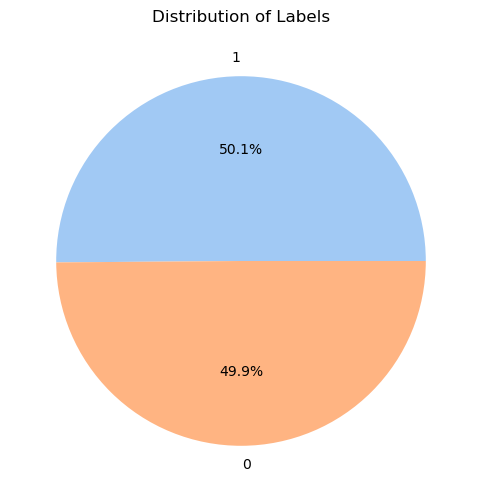

In [42]:
import seaborn as sns
plt.figure(figsize=(8, 6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', colors=sns.color_palette('pastel'))
plt.title('Distribution of Labels')
plt.show()

### Preprocessing the text

In [43]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    tokens = word_tokenize(text)
    
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    
    preprocessed_text = ' '.join(lemmatized_tokens)
    return preprocessed_text

data['message'] = data['message'].apply(preprocess_text)

### Vectorizing the text data

In [44]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3))
tfidf_vectorized_data = tfidf_vectorizer.fit_transform(data['message'])

### Split data into train and test sets

In [45]:
x = tfidf_vectorized_data
y = data['label']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

### Training the model

In [46]:
model = MultinomialNB()
model.fit(x_train, y_train)

MultinomialNB()

### Make predictions

In [47]:
y_pred = model.predict(x_test)

### Evaluate the model

Test accuracy: 100.00%
[[39  0]
 [ 0 44]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        39
           1       1.00      1.00      1.00        44

    accuracy                           1.00        83
   macro avg       1.00      1.00      1.00        83
weighted avg       1.00      1.00      1.00        83



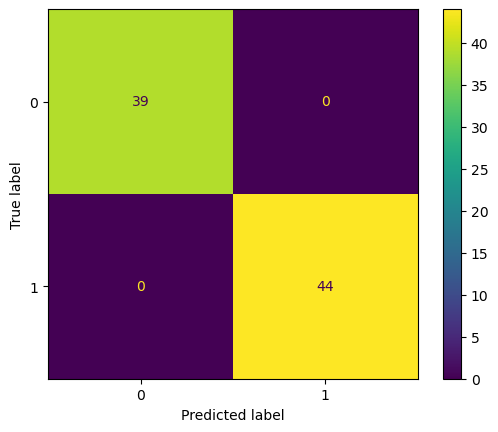

In [48]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy * 100:.2f}%")

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=[0, 1])
cm_display.plot()
plt.show()

### Save predictions to JSON

In [49]:
def predict_hipaa(input_text):
    processed_text = preprocess_text(input_text)
    X_input = tfidf_vectorizer.transform([processed_text])
    prediction = model.predict(X_input)
    prediction_text = 'HIPAA Data Detected' if prediction == 1 else 'No HIPAA Data Detected'
    result = {
        "Text": input_text,
        "Prediction": prediction_text
    }
    return result

user_input = input("Enter the text: ")
prediction_result = predict_hipaa(user_input)

json_file = "hipaa_output.json"
if os.path.isfile(json_file):
    df = pd.read_json(json_file, orient="records")
else:
    df = pd.DataFrame()

df = df.append(prediction_result, ignore_index=True)
df.to_json(json_file, orient="records")

print("Prediction result has been saved to hipaa_output.json")

Prediction result has been saved to hipaa_output.json


C:\Users\pvssu\AppData\Local\Temp\ipykernel_12188\2298429833.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(prediction_result, ignore_index=True)


### Loading JSON Data into MongoDB

In [50]:
import json
from pymongo import MongoClient

def load_json_to_mongodb(json_file_path, db_name, collection_name, mongo_uri="mongodb://localhost:27017"):
    client = MongoClient(mongo_uri)

    db = client[db_name]

    collection = db[collection_name]

    with open(json_file_path, 'r') as file:
        data = json.load(file)
        if isinstance(data, list):
            collection.insert_many(data)
        else:
            collection.insert_one(data)

    print(f"Data from {json_file_path} has been successfully imported into the {db_name}.{collection_name} collection.")

### Usage

In [51]:

json_file_path = 'hipaa_output.json'
db_name = 'hipaaDB'
collection_name = 'hipaaCollection'

load_json_to_mongodb(json_file_path, db_name, collection_name)

Data from hipaa_output.json has been successfully imported into the hipaaDB.hipaaCollection collection.
